# Co je steganografie?
Steganografie je technika skrytí tajných dat v běžném, netajném, souboru nebo zprávě, aby se zabránilo detekci; tajná data se pak extrahují na místo určení.

Klíčovým rozdílem je použití "klíče" v kryptografii pro převod prostého textu na šifrový text, který by zajistil, že uživatel nemůže skryté zprávě porozumět. Zatímco ve steganografii jsou informace skryty tak, že struktura krycí částice se nemění a samotná skutečnost, že zpráva je skrytá, není známa.

***Steganalýza*** je proces detekce skrytých dat, která jsou  pomocí steganografie. Steganografie a steganalýza jsou analogické šifrování a dešifrování.

![Alt Text](pictures/Block-diagram-of-Steganalysis.png)


Budeme používat dataset ze soutěže kaggle známé jako ALASKA2 Image Steganalysis.
Tato datová sada se skládá ze 75K krycích obrázků, což znamená, že tyto obrázky nemají v nich vloženou skrytou zprávu. Skládá se také 75k obrázků každý ve složkách s názvem JMiPOD, JUNIWARD a UERD. Jedná se v podstatě o tři moderní algoritmy steganografie, a obrázky v těchto složkách vypadají přesně jako titulní obrázky, ale na základě těchto algoritmů jsou do nich vloženy tajné zprávy.

Pro tento experiment budu zvažovat pouze algoritmus JUNIWARD a obrázky **7500** každý ze složek **JUNIWARD** a cover images.

![Alt Text](pictures/dataset.png)

Nejprve importujeme všechny liby, které jsou v tomto bodě vyžadovány 

In [9]:
import pandas as pd
from stegano import lsb
import os
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image
import scipy.spatial.distance as dist
import string
import random
from essential_generators import DocumentGenerator
from scipy.fftpack import dct
from skimage.io import imread
from tqdm import tqdm

Tento úryvek kódu definuje a volá funkci, která otevře pět náhodných obrázků ve složce cover image a zobrazí je.

Encoding secert message in cover image number 20162.jpg
Encoding secert message in cover image number 16422.jpg
Encoding secert message in cover image number 70963.jpg
Encoding secert message in cover image number 54809.jpg
Encoding secert message in cover image number 65721.jpg


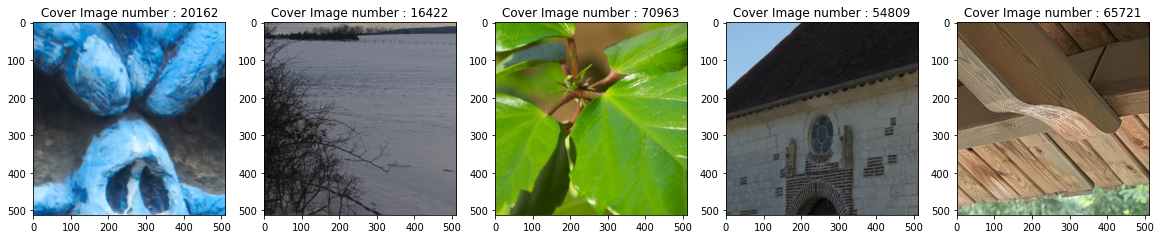

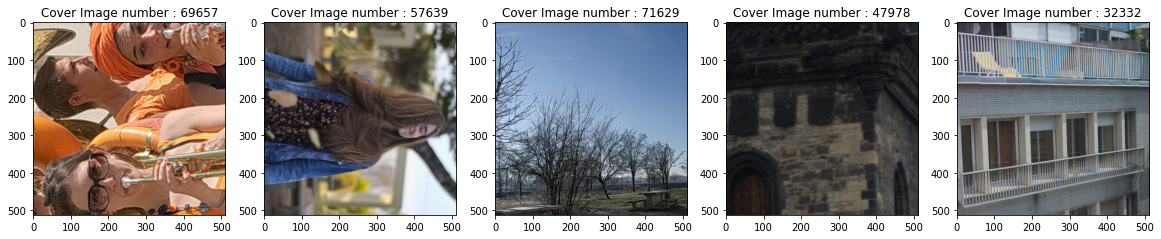

In [10]:
cover_path= "alaska2-image-steganalysis/cover"
JUNIWARD_path = "alaska2-image-steganalysis/JUNIWARD"



def get_cover_image(cover_path):
    cover_image_list=[]
    fig,axes = plt.subplots(ncols=5, figsize = (20,20) )

    for i,img in enumerate(np.random.randint(0,len(os.listdir(cover_path)),5)):
        img_name=str(img)
        if len(img_name) <5:
            img_name="0"*(5-len(img_name))+img_name
        try:
            cover_image=plt.imread(cover_path+"/"+img_name+".jpg")
            axes[i].imshow(cover_image)
            axes[i].set_title("Cover Image number : {}".format(img_name))
        except:
            img_name=str(int(img_name)+5)
            cover_image=plt.imread(cover_path+"/"+img_name+".jpg")
            axes[i].imshow(cover_image)
            axes[i].set_title("Cover Image number : {}".format(img_name))
        cover_image_list.append(cover_path+"/"+img_name+".jpg")

    return cover_image_list

cover_image_list=get_cover_image(cover_path)


juniward_image_list = get_cover_image(JUNIWARD_path)


def encode_secert(cover_image_list):
    encoded_list=[]
    gen = DocumentGenerator()

    if not os.path.exists("alaska2-image-steganalysis/encode_part1"):
        os.mkdir("alaska2-image-steganalysis/encode_part1")

    for img in cover_image_list:
        print("Encoding secert message in cover image number {}".format(img.split("/")[2]))
        img_jpeg= Image.open(img)
        encode=lsb.hide(img_jpeg,gen.sentence())
        encode.save("alaska2-image-steganalysis/encode_part1/"+img.split("/")[2])
        encoded_list.append(encode)

    return encoded_list

encoded_list=encode_secert(cover_image_list)


Než se podíváme na JUNIWARD (kódovaná) data, použijme zajímavý modul s názvem stegano, který jsem objevil při výzkumu tohoto projektu.
Zde máme funkci, která používá **stegano**, která kóduje text a další modul nazvaný essential_generators. **DocumentGenerator**, který náhodně konstruuje věty, které použijeme k zakódování do našich obrázků.
Pod kapotou **stegano** kóduje naši zprávu do nejméně významných bitů (LSBs) obrázků. Vzhledem k tomu, že změny v LSBs nezmění vzhled obrazu, plníme cíl steganografie.

In [11]:
def decode_secret(cover_image_list,encoded_list):
    
    for encode,img in zip(encoded_list,cover_image_list):
        print("Encoded message in cover image number {} is -> {} ".format(img.split("/")[2],lsb.reveal(encode)))
        
decode_secret(cover_image_list,encoded_list)


Encoded message in cover image number 20162.jpg is -> XML, HTML, foster our own associations. 
Encoded message in cover image number 16422.jpg is -> Territories though the Orinoco River system. 
Encoded message in cover image number 70963.jpg is -> Whose comedy Generator QRNG Fast 
Encoded message in cover image number 54809.jpg is -> Arctic ice differences (personal 
Encoded message in cover image number 65721.jpg is -> Branches of the Underground Railroad. Upstate. 


# Impact of JPEG in Steganography
### YCbCr channels
* Kanál Y vyjadřuje intenzitu světla v obraze. Tento kanál je citlivější na lidské oko, a proto je výraznější než kanály Cb a Cr.
* Kanál Cb ukazuje modrou složku vzhledem k zelené složce a kanál *Cr* ukazuje červenou složku vzhledem k modré složce.
* Cílem je komprimovat náš původní obraz takovým způsobem, že rozdíl je pro diváka nevýznamný.
Vykreslujme naše krycí obrázky s těmito kanály vedle sebe a pozorujme rozdíly.

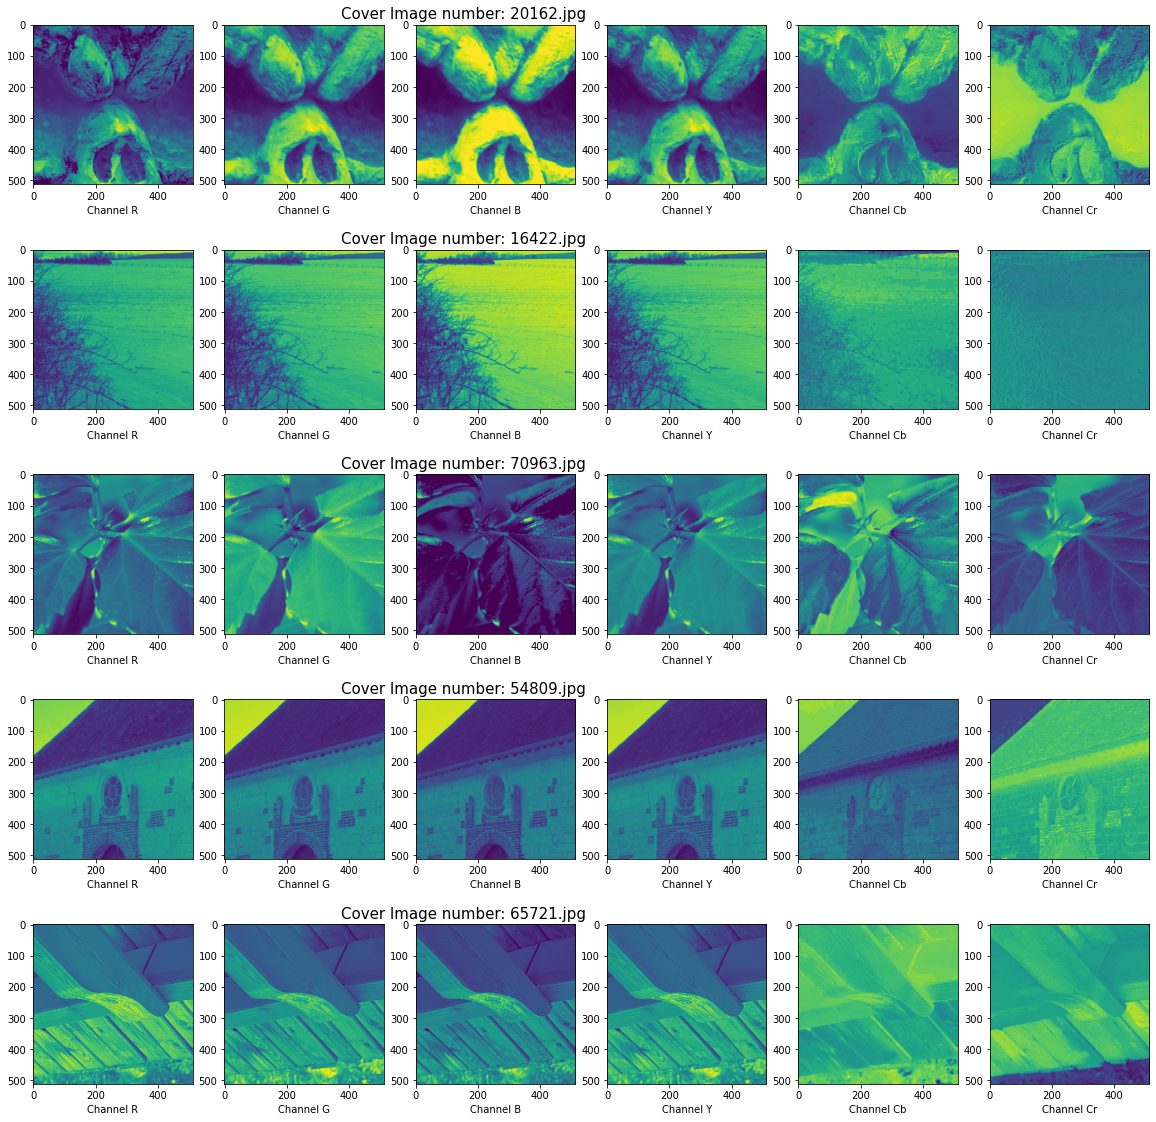

In [12]:
def YCbCr_channel(cover_image_list,title):
    fig,axes = plt.subplots(ncols=6,nrows=5, figsize = (20,20) )
    for i,img in enumerate(cover_image_list):
        im1 = Image.open(img)
        im1_ycbcr = im1.convert('YCbCr')
        y1, cb1, cr1 = im1_ycbcr.split()
        r,g,b=im1.split()
        axes[i][0].imshow(r)
        axes[i][0].set_xlabel("Channel R")
        axes[i][1].imshow(g)
        axes[i][1].set_xlabel("Channel G")
        axes[i][2].imshow(b)
        axes[i][2].set_xlabel("Channel B")
        axes[i][3].imshow(y1)
        axes[i][3].set_xlabel("Channel Y")
        axes[i][4].imshow(cb1)
        axes[i][4].set_xlabel("Channel Cb")
        axes[i][5].imshow(cr1)
        axes[i][5].set_xlabel("Channel Cr")

    for ax, row in zip(axes[:,0], cover_image_list):
        ax.set_title(title.format(row.split("/")[2]),size=15,x=2.7,y=1.)

YCbCr_channel(cover_image_list,title="Cover Image number: {}")

Nyní můžeme pozorovat, že kanál Y je zcela odlišný od kanálů Cb a Cr a účel komprese je v těchto kanálech splněn.
Přejděme nyní k bloku algoritmu komprese JPEG, kde JUNIWARDŮV algoritmus skrývá tajný text.

### Diskrétní Kosinová Transformace (Discrete Cosine Transform)

Jedná se o techniku umožňující konverzi signálu na elementární frekvenční složky. DKT jedná se o ztrátový algoritmus, který se snaží zlikvidovat vysokofrekvenční komponenty a udržet "důležité" nízkofrekvenční komponenty, které jsou citlivější na lidské oko.
DCT koeficienty se zdají být opravdu bezpečnou verzí obrazu pro praxi steganografie, protože musíme projít kanály RGB a YCbCr, abychom toho dosáhli.
Nyní, že víme, o DCT koeficienty, pojďme převést naše krytí a JUNIWARD obrázky do jejich DCT koeficienty zkontrolovat, zda můžeme použít jako funkce pro náš model.

In [13]:
def dct_conversion(cover_image_list,juniward_image_list):
    for img,j_img in zip(cover_image_list,juniward_image_list):
        im = Image.open(img)
        j_im=Image.open(j_img)
        im = im.convert('YCbCr')
        j_im = j_im.convert('YCbCr')
        im = np.array(im)
        j_im=np.array(j_im)
        sim=1-np.abs(dist.cosine(dct(im).reshape(-1),dct(j_im).reshape(-1)))
        print("Cosine similarity between {} cover image and encoded image is {}".format(img.split("/")[2],sim))

dct_conversion(cover_image_list,juniward_image_list)

Cosine similarity between 20162.jpg cover image and encoded image is 0.9265985506592628
Cosine similarity between 16422.jpg cover image and encoded image is 0.9684640192604927
Cosine similarity between 70963.jpg cover image and encoded image is 0.9543843921345718
Cosine similarity between 54809.jpg cover image and encoded image is 0.9715460675414426
Cosine similarity between 65721.jpg cover image and encoded image is 0.9637723029560085


### Training a Convolutional Neural Network

In [14]:
cover_final_path="alaska2-image-steganalysis/Cover"
juniward_final_path="alaska2-image-steganalysis/JUNIWARD"
cover_final_path_list=[]
juniward_final_path_list=[]
pixel_cover=[]
pixel_juniward=[]


def get_train_data(cover_final_path,juniward_final_path):
    train_df=pd.DataFrame()
    train_df_2=pd.DataFrame()
    for path in tqdm(os.listdir(cover_final_path)[:7500]):
        cover_final_path_list.append(cover_final_path+"/"+path)
        im = Image.open(cover_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((200,200),1)
        im=np.array(im)
        pixel_cover.append(im)
    train_df["Images"]=cover_final_path_list
    train_df["Label"]=0

    for path in tqdm(os.listdir(juniward_final_path)[:7500]):
        juniward_final_path_list.append(juniward_final_path+"/"+path)
        im = Image.open(juniward_final_path+"/"+path)
        im = im.convert('L')
        im=im.resize((200,200),1)
        im=np.array(im)
        pixel_juniward.append(im)
    train_df_2["Images"]=juniward_final_path_list
    train_df_2["Label"]=1

    train_df=train_df.append(train_df_2)
    return train_df,pixel_cover,pixel_juniward


train_df,pixel_cover,pixel_juniward=get_train_data(cover_final_path,juniward_final_path)

Y=train_df["Label"].values
pixel_cover=np.array(pixel_cover)
pixel_juniward=np.array(pixel_juniward)
X=np.concatenate([pixel_cover,pixel_juniward])
X=X.reshape(15000,200,200,1)

100%|██████████| 7500/7500 [00:45<00:00, 163.40it/s]


Náš model je sekvenční model s více vrstvami sestávajícími z bloků Conv2D, MaxPooling2D a BatchNormalization. Budeme měřit naši ztrátu pomocí střední kvadratické chyby a budeme používat adam jako náš optimalizátor.

#### Conv2D
![Alt Text](pictures/conv2d.png)

Tato vrstva vytváří konvoluční jádro, které je konvolvováno se vstupem vrstvy a vytváří tenzor výstupů. Pokud je use_bias pravdivý, vytvoří se bias vektor a přidá se k výstupům. Nakonec, pokud Aktivace není žádná, aplikuje se také na výstupy.

Při použití této vrstvy jako první vrstva v modelu, poskytovat klíčové slovo argument input_shape (n-tice celých čísel, nebo Nic, nezahrnuje vzorku osy), např. input_shape=(128, 128, 3) pro 128x128 RGB obrázky v data_format="channels_last". Žádný nelze použít, pokud má rozměr proměnnou velikost.

#### MaxPooling2D
![Alt Text](pictures/Screenshot-2019-07-21-at-2.57.13-AM.png)

Maximální operace sdružování pro 2D prostorová data.

Downsamples vstup podél jeho prostorových rozměrů (výška a šířka) tím, že maximální hodnotu přes vstupní okno (o velikosti definované pool_size) pro každý kanál vstupu. Okno je posunuto o kroky podél každé dimenze.

Výsledný výstup při použití volby "valid" má prostorový tvar (počet řádků nebo sloupců): output_shape = math.podlaha ((input_shape - pool_size) / kroky) + 1 (při input_shape >= pool_size)

#### Batch Normalization
![Alt Text](pictures/batch.png)
Normalizace dávky aplikuje transformaci, která udržuje střední výstup blízko 0 a výstupní směrodatnou odchylku Blízko 1.

Důležité je, že normalizace dávky funguje odlišně během tréninku a během inference.


In [15]:
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import BatchNormalization

model = Sequential()
model.add(Conv2D(128, kernel_size = (3, 3), activation='relu', input_shape=(200,200,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(BatchNormalization())
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam')
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 198, 198, 128)     1280      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 99, 99, 128)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 99, 99, 128)       512       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 97, 97, 64)        73792     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 48, 48, 64)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 46, 46, 64)       

In [16]:
model.fit(X, Y, batch_size = 100, epochs = 7,validation_split=0.2)

Epoch 1/7
120/120 [==============================] - 2709s 22s/step - loss: 0.5614 - val_loss: 0.8638
Epoch 2/7
120/120 [==============================] - 2533s 21s/step - loss: 0.3250 - val_loss: 0.4747
Epoch 3/7
120/120 [==============================] - 2100s 17s/step - loss: 0.2942 - val_loss: 0.4614
Epoch 4/7
120/120 [==============================] - 2090s 17s/step - loss: 0.2681 - val_loss: 0.4402
Epoch 5/7
120/120 [==============================] - 1959s 16s/step - loss: 0.2598 - val_loss: 0.5571
Epoch 6/7
120/120 [==============================] - 2000s 17s/step - loss: 0.2587 - val_loss: 0.4458
Epoch 7/7
120/120 [==============================] - 2063s 17s/step - loss: 0.2540 - val_loss: 0.2834


In [17]:
model.save('my_model3_20epoch')

INFO:tensorflow:Assets written to: my_model3_20epoch\assets


In [21]:
reconstructed_model = keras.models.load_model("my_model3_20epoch")

predict_result = reconstructed_model.predict(X);

 

In [22]:
for i in predict_result:
    print(i)

[0.45153615]
[0.10120054]
[0.55434436]
[0.5624064]
[0.52793634]
[0.54766077]
[0.16293359]
[0.48395142]
[0.38272008]
[0.26920074]
[0.5241293]
[0.5553315]
[0.43710947]
[0.55424273]
[0.4468332]
[0.28895164]
[0.42569104]
[0.4370021]
[0.29799542]
[0.5188673]
[0.36414903]
[0.5244727]
[0.30127943]
[0.48332822]
[0.48392808]
[0.58483154]
[0.52731115]
[0.5718704]
[0.51596725]
[0.5807091]
[0.5576539]
[0.4796707]
[0.4525571]
[0.5524834]
[0.53561836]
[0.54263586]
[0.52404773]
[0.53634053]
[0.55843604]
[0.55711526]
[0.40321168]
[0.55358875]
[0.5578382]
[0.54396224]
[0.5150332]
[0.5562773]
[0.5454212]
[0.55356914]
[0.5492779]
[0.47289482]
[0.51524353]
[0.5565634]
[0.49957284]
[0.5561854]
[0.5754063]
[0.5350871]
[0.33429855]
[0.54497445]
[0.4882055]
[0.53172815]
[0.5462769]
[0.5477086]
[0.51856947]
[0.46363476]
[0.5362241]
[0.5522703]
[0.5373386]
[0.5554067]
[0.5139171]
[0.5298629]
[0.33518282]
[0.5522983]
[0.52794296]
[0.5270515]
[0.5558934]
[0.54183435]
[0.52379495]
[0.5610319]
[0.5147944]
[0.542048

[0.55505025]
[0.53978825]
[0.231071]
[0.55238795]
[0.5394918]
[0.35219142]
[0.5576453]
[0.5469299]
[0.5576]
[0.5049789]
[0.45353186]
[0.49416566]
[0.554248]
[0.34351745]
[0.43444285]
[0.53181124]
[0.25806826]
[0.5257486]
[0.32410827]
[0.53651744]
[0.43362576]
[0.5526389]
[0.53402376]
[0.5238327]
[0.5226177]
[0.4659331]
[0.5556841]
[0.4157502]
[0.5199769]
[0.5083722]
[0.4912132]
[0.5799033]
[0.5434978]
[0.5352312]
[0.5573092]
[0.44890213]
[0.5633622]
[0.59219337]
[0.507657]
[0.5514873]
[0.5753591]
[0.42086717]
[0.5605155]
[0.5116834]
[0.45450824]
[0.41238466]
[0.5159811]
[0.0218057]
[0.3830922]
[0.2246742]
[0.5689816]
[0.5503362]
[0.542906]
[0.37170094]
[0.43287465]
[0.52201194]
[0.5385145]
[0.4693849]
[0.54160684]
[0.5248446]
[0.5179863]
[0.50741374]
[0.1837265]
[0.5473664]
[0.31847924]
[0.5598426]
[0.5524168]
[0.53648037]
[0.25607538]
[0.49732396]
[0.5120536]
[0.56351125]
[0.271376]
[0.21827188]
[0.51508564]
[0.33217376]
[0.45970717]
[0.5449063]
[0.39562032]
[0.4356135]
[0.47161663]
[

[0.46998402]
[0.54048944]
[0.3196339]
[0.5609292]
[0.51887816]
[0.53346694]
[0.5653426]
[0.5400737]
[0.40805992]
[0.4749308]
[0.55705774]
[0.54590344]
[0.4586991]
[0.5553463]
[0.54536164]
[0.2797069]
[0.32985252]
[0.40269694]
[0.5514022]
[0.55176485]
[0.5930942]
[0.54794586]
[0.49268574]
[-0.02755371]
[0.21293971]
[0.21431598]
[0.49627623]
[0.55133855]
[0.49893248]
[0.6756221]
[0.31993765]
[0.04477741]
[0.52335334]
[0.5424074]
[0.27624288]
[0.37380987]
[0.53848064]
[0.2755388]
[0.54791224]
[0.33261538]
[0.29459378]
[0.58693206]
[0.3780694]
[0.5314916]
[0.5560322]
[0.5590539]
[0.549793]
[0.5448514]
[0.26882634]
[0.33583033]
[0.52492595]
[0.51987696]
[0.5346469]
[0.54827]
[0.5258178]
[0.5521898]
[0.52484155]
[0.4014451]
[0.42563412]
[0.51786083]
[0.4839379]
[0.55160296]
[0.47560346]
[0.13181832]
[0.5567777]
[0.5675577]
[0.38644394]
[0.55738735]
[0.56159616]
[0.40726694]
[0.39146665]
[0.56703377]
[0.5031807]
[0.27389657]
[0.24078336]
[0.3292268]
[0.5743153]
[0.5532787]
[0.5568157]
[0.1443

[0.55460966]
[0.56275034]
[0.54915416]
[0.37595797]
[0.49341887]
[0.5608314]
[0.4548328]
[0.5145886]
[0.5318012]
[0.54599005]
[0.5555682]
[0.26450518]
[0.55723935]
[0.5639628]
[0.55710286]
[0.553965]
[0.56907904]
[0.42964464]
[0.53552705]
[0.53590155]
[0.32363316]
[0.5253975]
[0.55408436]
[0.5542133]
[0.55027676]
[0.16341345]
[0.5538186]
[0.5643469]
[0.4248032]
[0.3830707]
[0.56324255]
[0.54050744]
[0.15235223]
[0.36722162]
[0.52501655]
[0.5467262]
[0.5436504]
[0.33641225]
[0.53137827]
[0.36783272]
[0.5308615]
[0.49580252]
[0.553118]
[0.53194284]
[0.5500799]
[0.5178678]
[0.54710585]
[0.5267633]
[0.56261957]
[0.5477178]
[0.5065479]
[0.55619085]
[0.544561]
[0.5327852]
[0.3826585]
[0.5114666]
[0.56426895]
[0.35860246]
[0.2562251]
[0.5507412]
[0.42051783]
[0.39493752]
[0.5280006]
[0.14907128]
[0.5510191]
[0.5390788]
[0.5397017]
[0.5368657]
[0.5352201]
[0.53026235]
[0.5468458]
[0.548922]
[0.5701215]
[0.48889]
[0.5499346]
[0.39317662]
[0.48718083]
[0.543468]
[0.49653327]
[0.52422625]
[0.5492

[0.4633062]
[0.20323542]
[0.23616733]
[0.5418892]
[0.52124006]
[0.53295803]
[0.41454235]
[0.5451813]
[0.4339519]
[0.53758836]
[0.18296982]
[0.43740636]
[0.15050358]
[0.58117616]
[0.65188766]
[0.39514008]
[0.5567254]
[0.34753463]
[0.38765907]
[0.52678037]
[0.47893322]
[0.24410777]
[0.54219407]
[0.31635696]
[0.3481307]
[0.5536709]
[0.55002415]
[0.5572777]
[0.5411114]
[0.50781393]
[0.9579086]
[0.32555842]
[0.54273355]
[0.45250267]
[0.55768794]
[0.52782035]
[0.55324656]
[0.18973476]
[0.56085724]
[0.25181752]
[0.43316984]
[0.58278954]
[0.5422523]
[0.4713719]
[0.41298783]
[0.5540626]
[0.5496675]
[0.5704105]
[0.5316755]
[0.55938554]
[0.51364696]
[0.35771787]
[0.51519036]
[0.54270077]
[0.5358009]
[0.53182757]
[0.58343977]
[0.5088209]
[0.5050313]
[0.28666657]
[0.28363928]
[0.16337872]
[0.5364932]
[0.17274237]
[0.2921006]
[0.54574025]
[0.55535805]
[0.5623923]
[0.5529686]
[0.5221435]
[0.50578296]
[0.49376953]
[0.5277977]
[0.50677824]
[0.18805102]
[0.4615503]
[0.41204983]
[0.5530689]
[0.46947712]


[0.40400523]
[0.44374204]
[0.5596392]
[0.51116264]
[0.53788793]
[0.54114866]
[0.35664576]
[0.3092224]
[0.3260201]
[0.5347992]
[0.538732]
[0.49330342]
[0.5168778]
[0.45814532]
[0.54503536]
[0.23594382]
[0.54467887]
[0.41864383]
[0.56719804]
[0.359551]
[0.23929965]
[0.38451046]
[0.5512054]
[0.5601641]
[0.47093096]
[0.5118693]
[0.53762233]
[0.52086765]
[0.56523204]
[0.52851146]
[0.5295072]
[0.32728863]
[0.3677348]
[0.52931356]
[0.5191144]
[0.30519688]
[0.53821796]
[0.54356396]
[0.5250074]
[0.31248426]
[0.5503468]
[0.49731934]
[0.529166]
[0.549008]
[0.4155495]
[0.5193843]
[0.29322764]
[0.5549162]
[0.58032477]
[0.43698427]
[0.5265291]
[0.6092186]
[0.5569197]
[0.14159991]
[0.5512893]
[0.2985751]
[0.5210093]
[0.36365777]
[0.5570959]
[0.546222]
[0.5316827]
[0.5555246]
[0.30382758]
[0.5561116]
[0.53202236]
[0.4322584]
[0.54086906]
[0.43850508]
[0.3696313]
[0.45061827]
[0.33076262]
[0.5221641]
[0.29900625]
[0.57614225]
[0.48270807]
[0.5060841]
[0.3954259]
[0.5546407]
[0.57354665]
[0.38378832]
[0

[0.25932187]
[0.5451213]
[0.5510005]
[0.583735]
[0.53731465]
[0.47539437]
[0.5402312]
[0.6755489]
[0.28244364]
[0.2454805]
[0.5831132]
[0.55157995]
[0.55382276]
[0.29229355]
[0.48311275]
[0.34185916]
[0.53898335]
[0.5319366]
[0.54624426]
[0.05477446]
[0.2854011]
[0.54544353]
[0.37179846]
[0.31027475]
[0.5576154]
[0.7246073]
[0.3922256]
[0.3912929]
[0.34513015]
[0.5143105]
[0.5509716]
[0.5418384]
[0.5067378]
[0.46109027]
[0.52083564]
[0.53647935]
[0.54034317]
[0.5376954]
[0.48857567]
[0.5481794]
[0.5495833]
[0.33584893]
[0.42982662]
[0.56383705]
[0.55963945]
[0.5273876]
[0.5567436]
[0.58729]
[0.3033706]
[0.54824805]
[0.53514755]
[0.5098831]
[0.53996587]
[0.5188645]
[0.5029773]
[0.56633747]
[0.3044483]
[0.52155507]
[0.44163918]
[0.57675225]
[0.5587522]
[0.48652375]
[0.39526427]
[0.34874123]
[0.27003506]
[0.48525536]
[0.21942843]
[0.4340551]
[0.50710773]
[0.53137314]
[0.4863946]
[0.5541398]
[0.36367798]
[0.5043665]
[0.5080554]
[0.5284182]
[0.50083935]
[0.56210434]
[0.27981934]
[0.51525456

[0.95736766]
[0.48521915]
[0.454462]
[0.5176884]
[0.3526859]
[0.47762144]
[0.35622835]
[0.57736826]
[0.5165729]
[0.53174514]
[0.09741832]
[0.5539191]
[0.528213]
[0.37862927]
[0.55543035]
[0.5437697]
[0.47114158]
[0.5357886]
[0.54455066]
[0.45571694]
[0.57071716]
[0.5491942]
[0.48116136]
[0.46820638]
[0.5614401]
[0.41505566]
[0.51405144]
[0.3698832]
[0.5170664]
[0.25717112]
[0.40895092]
[0.20522997]
[0.49394676]
[0.57299095]
[0.58310604]
[0.46958205]
[0.36757064]
[0.53614295]
[-0.18214859]
[0.53724885]
[0.5542614]
[0.5398002]
[0.33256936]
[0.09742129]
[0.53098035]
[0.42403197]
[0.5532801]
[0.5015644]
[0.26283696]
[0.5294262]
[0.45521742]
[0.5510613]
[0.5476176]
[0.5205836]
[0.5900547]
[0.50653523]
[0.33925402]
[0.56099904]
[0.26451787]
[0.53965425]
[0.39846668]
[0.5413568]
[0.529303]
[0.43964362]
[0.30976087]
[0.4763952]
[0.51076937]
[0.551707]
[0.56238663]
[0.52465004]
[0.5659287]
[0.5247381]
[0.55573547]
[0.37332377]
[0.42970136]
[0.5620938]
[0.5309458]
[0.02898493]
[0.55054474]
[0.50

[0.331387]
[0.561492]
[0.34091645]
[0.5106573]
[0.474487]
[0.55416363]
[0.53041434]
[0.559194]
[0.50247866]
[0.53071564]
[0.5565213]
[0.5198604]
[0.54121906]
[0.52171224]
[0.54965836]
[0.54375386]
[0.48579636]
[0.3719977]
[0.19969587]
[0.5481981]
[0.41249174]
[0.5767479]
[0.5150617]
[0.33912215]
[0.5466532]
[0.5304134]
[0.3467306]
[0.546169]
[0.50795686]
[0.27984232]
[0.3745158]
[0.4992978]
[0.5221864]
[0.51793784]
[0.45990214]
[0.53429115]
[0.5457779]
[0.4180991]
[0.5100704]
[0.30139226]
[0.46020567]
[0.32570186]
[0.41141158]
[0.41036093]
[0.57151777]
[0.41234463]
[0.4224925]
[0.5498991]
[0.5509303]
[0.54468393]
[0.3884508]
[0.5568122]
[0.5647501]
[0.4491105]
[0.5212766]
[0.46718165]
[0.3693232]
[0.536199]
[0.54080844]
[0.40976474]
[0.55017847]
[0.54411024]
[0.53534657]
[0.40139094]
[0.56035626]
[0.5075802]
[0.53757256]
[0.5618609]
[0.3053869]
[0.5338696]
[0.5416291]
[0.35921633]
[0.48368996]
[0.42300522]
[0.47328907]
[0.39319265]
[0.55806744]
[0.526299]
[0.5434326]
[0.56041634]
[0.48

[0.54543835]
[0.55975235]
[0.3771759]
[0.37143847]
[0.35340652]
[0.37833232]
[0.36631125]
[0.5386727]
[0.44508693]
[0.5787673]
[0.45570028]
[0.45166954]
[0.5299301]
[0.29801282]
[0.5783398]
[0.56467426]
[0.5317366]
[0.3637784]
[0.5570904]
[0.5393397]
[0.3558842]
[0.55508107]
[0.52571785]
[0.5362539]
[0.53976244]
[0.51239836]
[0.2998101]
[0.26902047]
[0.55226934]
[0.43921328]
[0.45998892]
[0.5195524]
[0.554463]
[0.443994]
[0.5407258]
[0.5073123]
[0.3890123]
[0.52444756]
[0.5472543]
[0.40534627]
[0.5429643]
[0.4374447]
[0.5535841]
[0.47077402]
[0.53663146]
[0.5467337]
[0.40500036]
[0.25529814]
[0.5665663]
[0.30434996]
[0.5267862]
[0.3504694]
[0.51077306]
[0.31954187]
[0.49567217]
[0.53470993]
[0.5448841]
[0.37335253]
[0.6164398]
[0.37305132]
[0.5060568]
[0.4413823]
[0.52227104]
[0.5440319]
[0.5536885]
[0.49934682]
[0.3756259]
[0.53331447]
[0.4698013]
[0.5544586]
[0.5483644]
[0.5319241]
[0.5628641]
[0.53325313]
[0.518672]
[0.29001868]
[0.5951076]
[0.51862943]
[0.57533306]
[0.38338012]
[0.

[0.5922153]
[0.58728445]
[0.55277264]
[0.52871096]
[0.45890576]
[0.54903066]
[0.495533]
[0.14526558]
[0.54783]
[0.5537429]
[0.54615045]
[0.5582075]
[0.55545735]
[0.5558164]
[0.5284569]
[0.3626488]
[0.51693714]
[0.38540116]
[0.47950873]
[0.55640316]
[0.5858562]
[0.556002]
[0.34386778]
[0.41262472]
[0.5560349]
[0.12817448]
[0.56430924]
[0.50338936]
[0.40756452]
[0.38577646]
[0.51080954]
[0.54100794]
[0.56089324]
[0.37442622]
[0.5490811]
[0.53997946]
[0.5609498]
[0.34304744]
[0.57979214]
[0.5072362]
[0.55901563]
[0.5599232]
[0.5415945]
[0.5651896]
[0.27373952]
[0.32832205]
[0.55764735]
[0.55004215]
[0.558751]
[0.5589936]
[0.5478729]
[0.55046695]
[0.5506023]
[0.5365772]
[0.5412071]
[0.55174166]
[0.5528858]
[0.5572313]
[0.5473462]
[0.06112599]
[0.5573274]
[0.51715153]
[0.5305427]
[0.5486168]
[0.5061016]
[0.54044795]
[0.49615127]
[0.3741164]
[0.52870476]
[0.5553293]
[0.4611593]
[0.53854275]
[0.44254363]
[0.5040623]
[0.5500713]
[0.4339311]
[0.5357875]
[0.5080683]
[0.52727854]
[0.66882443]
[0.

[0.552795]
[0.55224997]
[0.55816686]
[0.52035236]
[0.5974033]
[0.42705986]
[0.40000314]
[0.53472674]
[0.54581493]
[0.52924085]
[0.5239151]
[0.35343695]
[0.41896495]
[0.38225043]
[0.50288904]
[0.26037964]
[0.557895]
[0.55721366]
[0.5961803]
[0.5561335]
[0.57885915]
[0.51560295]
[0.5449147]
[0.5092863]
[0.56055975]
[0.39312923]
[0.36127794]
[0.5560847]
[0.5569484]
[0.46760225]
[0.40069723]
[0.55334437]
[0.4494908]
[0.48266882]
[0.24857017]
[0.49286312]
[0.43099433]
[0.53731996]
[0.22253203]
[0.52603686]
[0.16379492]
[0.52536047]
[0.56067777]
[0.54701805]
[0.53363276]
[0.5436022]
[0.3858275]
[0.55619586]
[0.5531889]
[0.55058515]
[0.38698518]
[0.55575657]
[0.6368669]
[0.5257468]
[-0.04648481]
[0.6000972]
[0.5658433]
[0.5477803]
[0.5706168]
[0.5455638]
[0.52590764]
[0.55176467]
[0.5600227]
[0.5493804]
[0.5517492]
[0.5409575]
[0.516583]
[0.52380687]
[0.55016047]
[0.50335366]
[0.60830635]
[0.52731514]
[0.25265598]
[0.5529259]
[0.4890379]
[0.42685992]
[0.55102885]
[0.5515706]
[0.5198406]
[0.57

[0.5657335]
[0.49935585]
[0.55164486]
[0.56796384]
[0.5244771]
[0.53853655]
[0.3789989]
[0.46544498]
[0.5671783]
[0.5444107]
[0.4354016]
[0.50865865]
[0.4621495]
[0.5305679]
[0.5436319]
[0.53559136]
[0.5342429]
[0.54787004]
[0.5719131]
[0.4620629]
[0.4653698]
[0.54401374]
[0.5533502]
[0.34996498]
[0.5299094]
[0.30111942]
[0.24962583]
[0.37358457]
[0.5449269]
[0.5417725]
[0.50837016]
[0.5185329]
[0.54368424]
[0.5605694]
[0.5698461]
[0.5343764]
[0.38514495]
[0.545197]
[0.52223426]
[0.50133777]
[0.5387929]
[0.5571124]
[0.46077198]
[0.44514117]
[0.5633532]
[0.17677212]
[0.53379667]
[0.5592303]
[0.32700372]
[0.50684315]
[0.5260131]
[0.46533078]
[0.5446631]
[0.4213065]
[0.53458154]
[0.28528416]
[0.55630934]
[0.48573303]
[0.5432555]
[0.5616196]
[0.55227554]
[0.50600237]
[0.24934077]
[0.5513764]
[0.5327424]
[0.5108318]
[0.5358327]
[0.5574626]
[0.5497337]
[0.54247296]
[0.40140426]
[0.32048944]
[0.382385]
[0.5364947]
[0.5643786]
[0.54582]
[0.5392002]
[0.41464096]
[0.47588283]
[0.5263562]
[0.5663

[0.5462735]
[0.38427413]
[0.4294026]
[0.4151022]
[0.49331805]
[0.42547828]
[0.49866462]
[0.38387415]
[0.53447545]
[0.54840064]
[0.55265296]
[0.38099092]
[0.42857397]
[0.5559803]
[0.45779276]
[0.29064417]
[0.38337386]
[0.25138113]
[0.50221294]
[0.4762888]
[0.55909765]
[0.38740748]
[0.5480722]
[0.26588437]
[0.32988942]
[0.5523205]
[0.38074133]
[0.54837203]
[0.337788]
[0.52226496]
[0.55987537]
[0.55502164]
[0.35362154]
[0.52676636]
[0.5872091]
[0.550236]
[0.4733131]
[0.4780314]
[0.5547525]
[0.5448405]
[0.54955506]
[0.34814414]
[0.53849524]
[0.3252299]
[0.3755266]
[0.46593332]
[0.5596222]
[0.508453]
[0.37504527]
[0.5096049]
[0.55397826]
[0.40318513]
[0.5227856]
[0.55080914]
[0.4430038]
[0.5547265]
[0.43197453]
[0.4883533]
[0.54758936]
[0.45472965]
[0.3740821]
[0.5518654]
[0.24275656]
[0.54001033]
[0.53425825]
[0.55383825]
[0.46463794]
[0.5639926]
[0.5123092]
[0.52897376]
[0.43562144]
[0.45688236]
[0.5526619]
[0.38715777]
[0.3199251]
[0.5472369]
[0.5278863]
[0.3161674]
[0.47865185]
[0.49832

[0.4279902]
[0.13757029]
[0.31731114]
[0.07307829]
[0.5710825]
[0.5093955]
[0.5309541]
[0.39934894]
[0.4953428]
[0.5269713]
[0.39545715]
[0.5540052]
[0.56054735]
[0.31473]
[0.56067485]
[0.4173925]
[0.45862508]
[0.13300395]
[0.5415185]
[0.5520581]
[0.4294665]
[0.32239205]
[0.482696]
[0.5610808]
[0.5461175]
[0.50471413]
[0.21509899]
[0.55520445]
[0.5320555]
[0.5494511]
[0.5101125]
[0.5060549]
[0.55543107]
[0.5444839]
[0.48039278]
[0.5439733]
[0.5015553]
[0.36475116]
[0.5780025]
[0.38146144]
[0.5371114]
[0.5247917]
[0.5053879]
[0.5286822]
[0.5349797]
[0.56036437]
[0.4387772]
[0.5380498]
[0.47383195]
[0.48865008]
[0.4044011]
[0.50463724]
[0.5455113]
[0.54535973]
[0.54190576]
[0.53845274]
[0.48724785]
[0.56006324]
[0.26986882]
[0.37546247]
[0.19457558]
[0.56707984]
[0.599164]
[0.53960997]
[0.19923618]
[0.56154895]
[0.2813069]
[0.55337805]
[0.50852597]
[0.34614375]
[0.41288292]
[0.28482407]
[0.53402567]
[0.29933292]
[0.5506735]
[0.5744159]
[0.55473655]
[0.42795992]
[0.44992414]
[0.5551939]
[

[0.5044097]
[0.5471491]
[0.27849433]
[0.31442904]
[0.53931946]
[0.5169258]
[0.532393]
[0.54939353]
[0.5521774]
[0.27414685]
[0.57077926]
[0.49458563]
[0.22195752]
[0.28820598]
[0.2568984]
[0.56210554]
[0.5575896]
[0.52623636]
[0.5480317]
[0.55904555]
[0.54726285]
[0.5079175]
[0.5231205]
[0.5394529]
[0.52328366]
[0.55866206]
[0.5184494]
[0.5533684]
[0.30556625]
[0.49664986]
[0.55913097]
[0.54691494]
[0.51767266]
[0.5202879]
[0.5363183]
[0.5369785]
[0.37240523]
[0.261054]
[0.45627463]
[0.54813975]
[0.16268483]
[0.54382694]
[0.16334903]
[0.556833]
[0.5626515]
[0.53488255]
[0.5025045]
[0.2635339]
[0.55867416]
[0.5379139]
[0.5000758]
[0.5755662]
[0.24482635]
[0.21460952]
[0.4957279]
[0.36326137]
[0.5149461]
[0.38997293]
[0.49977577]
[0.25850433]
[0.38300133]
[0.56111443]
[0.5140082]
[0.27098942]
[0.56600654]
[0.5620697]
[0.39299098]
[0.50040805]
[0.5386887]
[0.5470116]
[0.5348177]
[0.23933488]
[0.4948609]
[0.5568364]
[0.40137023]
[0.3263604]
[0.5552722]
[0.55109584]
[0.521831]
[0.4040551]
[

[0.31776643]
[0.4126724]
[0.53889465]
[0.3972072]
[0.25769442]
[0.54673076]
[0.40599498]
[0.53468525]
[0.5533584]
[0.14319435]
[0.38321117]
[0.55891675]
[0.38129348]
[0.5565669]
[0.54789853]
[0.22941121]
[0.35201108]
[0.5460823]
[0.41924998]
[0.5203248]
[0.48436707]
[0.5022581]
[0.4004472]
[0.55760634]
[0.38818377]
[0.53567976]
[0.33139348]
[0.55472195]
[0.30316257]
[0.5476364]
[0.41611546]
[0.81944275]
[0.55826586]
[0.28005475]
[0.55261016]
[0.5321682]
[0.48058116]
[0.23113465]
[0.33607495]
[0.3759681]
[0.5059597]
[0.54621947]
[0.5005776]
[0.53338975]
[0.5741744]
[0.4606176]
[0.40193182]
[0.49925858]
[0.43759787]
[0.54263747]
[0.5418523]
[0.5384673]
[0.42385167]
[0.02716555]
[0.5359753]
[0.46652347]
[0.52355456]
[0.49166062]
[0.3887316]
[0.5046991]
[0.37241948]
[0.31179816]
[0.41264206]
[0.51739717]
[0.49856982]
[0.5618231]
[0.56078386]
[0.23326975]
[0.2033953]
[0.90131164]
[0.5469306]
[0.5320626]
[0.0926244]
[0.298896]
[0.31754565]
[0.36974108]
[0.54117864]
[0.5563371]
[0.43827575]
[

[0.5974579]
[0.56194746]
[0.5529799]
[0.55738246]
[0.5448036]
[0.24848124]
[0.5323091]
[0.55268157]
[0.5419979]
[0.5220068]
[0.27764893]
[0.532316]
[0.4427186]
[0.49747473]
[0.56735075]
[0.5013174]
[0.2957729]
[0.54133195]
[0.50727165]
[0.5631107]
[0.54627997]
[0.32203412]
[0.5056281]
[0.55093586]
[0.5095607]
[0.5213908]
[0.5357677]
[0.4093248]
[0.44029242]
[0.49069083]
[0.4669454]
[0.46148843]
[0.3462565]
[0.41160774]
[0.5086052]
[0.25961423]
[0.5598408]
[0.5802518]
[0.47565866]
[0.3779062]
[0.52605337]
[0.37814337]
[0.19730738]
[0.52079284]
[0.55459744]
[0.3244918]
[0.39357463]
[0.54765224]
[0.31044137]
[0.34306628]
[0.5642433]
[0.54982316]
[0.5563241]
[0.43155143]
[0.5495093]
[0.5602497]
[0.5519288]
[0.546953]
[0.56016153]
[0.53045243]
[0.55043584]
[0.27041274]
[0.5456689]
[0.36353528]
[0.5419463]
[0.52483726]
[0.56914485]
[0.25314695]
[0.53910065]
[0.5297166]
[0.5603859]
[0.5281934]
[0.5317602]
[0.54572356]
[0.48490387]
[0.53165877]
[0.5390171]
[0.52461]
[0.53066224]
[0.42171234]
[

[0.17364183]
[0.35895848]
[0.5788848]
[0.23410869]
[0.5034468]
[0.47490776]
[0.2617439]
[0.53721696]
[0.5526665]
[0.54427505]
[0.55594134]
[0.5386765]
[0.6130694]
[0.55071306]
[0.55452716]
[0.55304873]
[0.5556545]
[0.55255836]
[0.40578324]
[0.54992735]
[0.5174989]
[0.55197906]
[0.5554144]
[0.5033504]
[0.5508414]
[0.44782656]
[0.49655867]
[0.5253073]
[0.5536198]
[0.24792618]
[0.55338895]
[0.54212564]
[0.49822843]
[0.5692234]
[0.5617826]
[0.5253655]
[0.5447045]
[0.5505631]
[0.57733446]
[0.30499548]
[0.5587317]
[0.35809082]
[0.5320165]
[0.45748335]
[0.5780668]
[0.5585848]
[0.4476233]
[0.54722303]
[0.5399145]
[0.48230264]
[0.5231849]
[0.5535606]
[0.53551567]
[0.55873954]
[0.5289731]
[0.43675527]
[0.5434189]
[0.5300734]
[0.46306726]
[0.2954509]
[0.49825373]
[0.5456581]
[0.54586697]
[0.5059583]
[0.55317265]
[0.39195627]
[0.45323148]
[0.26047578]
[0.5472181]
[0.41406357]
[0.5608763]
[0.56999713]
[0.2868429]
[0.54401326]
[0.5809432]
[0.5497439]
[0.3639853]
[0.54469746]
[0.52827567]
[0.42664495

In [ ]:
model.fit(X, Y, batch_size = 100, epochs = 10,validation_split=0.2)

Epoch 1/10
107/120 [=========================>....] - ETA: 6:52 - loss: 0.2486

In [ ]:
model.save('my_model2')

In [ ]:
reconstructed_model = keras.models.load_model("my_model2")

In [ ]:
 predict_result = reconstructed_model.predict(X);

model.predict(X), reconstructed_model.predict(X);
 

In [ ]:
predict_result

In [ ]:
for i in predict_result:
    print(i)